In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import tqdm
import datetime
from progressbar import ProgressBar

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
kiosks = pd.read_csv("./data/Austin_B-Cycle_Kiosk_Locations.csv")
trips_mapping = pd.read_csv("./data/Austin_B-Cycle_Trips_extended_ordered.csv", index_col=0)
weather = pd.read_csv('./data/weather.csv', index_col=0)
weather2 = pd.read_csv('./data/weather2.csv', index_col=0)
weather3 = pd.read_csv('./data/weather3.csv', index_col=0)

In [243]:
weather = pd.concat([weather, weather2, weather3], ignore_index=True)

In [244]:
hourly_checkouts = {}
for kiosk in trips_mapping['Checkout Kiosk'].unique():
    hourly_checkouts[kiosk] = pd.DataFrame(columns=['Day','Month','Year','DayofWeek', 'Hours', 'Temp', 'Precip', 'Wind Speed', 'Checkouts'])

In [245]:
hourly_checkouts = pd.DataFrame(columns=['Day','Month','Year','DayofWeek', 'Hours', 'Temp', 'Precip', 'Wind Speed', 'Checkouts'])

In [6]:
hourly_checkouts

,Day,Month,Year,DayofWeek,Hours,Temp,Precip,Wind Speed,Checkouts


In [246]:
for idx, row in trips_mapping.iterrows():
    day = row['Day']
    month = row['Month']
    year = row['Year']
    DayofWeek = row['Day of Week']
    Hours = int(row['Checkout Time'].split(':')[0])

    weather_row = weather.query('day==@day and month==@month and year==@year')
    Temp = 0
    Precip = 0
    WindSpeed = 0
    if len(weather_row) != 0:
        Temp = weather_row.iloc[0]['temp']
        Precip = weather_row.iloc[0]['precip']
        WindSpeed = weather_row.iloc[0]['wind speed']

    checkout_row = hourly_checkouts.query('Day==@day and Month==@month and Year==@year and DayofWeek==@DayofWeek and Hours==@Hours')
    if len(checkout_row) == 0:
        s = pd.Series([day,month,year,DayofWeek,Hours,Temp,Precip,WindSpeed,1],index=['Day','Month','Year','DayofWeek', 'Hours', 'Temp', 'Precip', 'Wind Speed', 'Checkouts'])
        hourly_checkouts = hourly_checkouts.append(s, ignore_index=True)
    else:
        current_row = checkout_row.iloc[0].name
        hourly_checkouts.loc[current_row, 'Checkouts'] += 1
            
            
hourly_checkouts.to_csv('./data/hourly_checkoutsNEW.csv',index=False)

In [5]:
hourly_checkouts = pd.read_csv('./data/hourly_checkoutsNEW.csv')

In [6]:
hourly_checkouts.head()

,Day,Month,Year,DayofWeek,Hours,Temp,Precip,Wind Speed,Checkouts
0,21.0,12.0,2013.0,5.0,9.0,47.75,0.0592,5.82,2.0
1,21.0,12.0,2013.0,5.0,10.0,47.75,0.0592,5.82,1.0
2,21.0,12.0,2013.0,5.0,13.0,47.75,0.0592,5.82,4.0
3,21.0,12.0,2013.0,5.0,14.0,47.75,0.0592,5.82,13.0
4,21.0,12.0,2013.0,5.0,15.0,47.75,0.0592,5.82,18.0


In [7]:
temp = hourly_checkouts[['Checkouts','Temp','Precip','Wind Speed']]

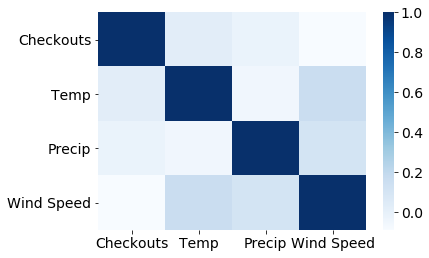

In [8]:
sns.heatmap(temp.corr(), cmap="Blues")

In [9]:
def dateTime(Year,Month,Day,Hours,Minutes,Seconds):
    return np.datetime64("{a:04d}-{b:02d}-{c:02d}T{d:02d}:{e:02d}:{f:02d}".format(a=int(Year),b=int(Month),c=int(Day),d=int(Hours),
                                                                     e=int(Minutes),f=int(Seconds)))
  
hourly_checkouts['datetime'] = hourly_checkouts.apply(lambda row: dateTime(row['Year'],row['Month'],row['Day'],row['Hours'],0,0), axis = 1)

In [10]:
hourly_checkouts = hourly_checkouts.set_index('datetime')

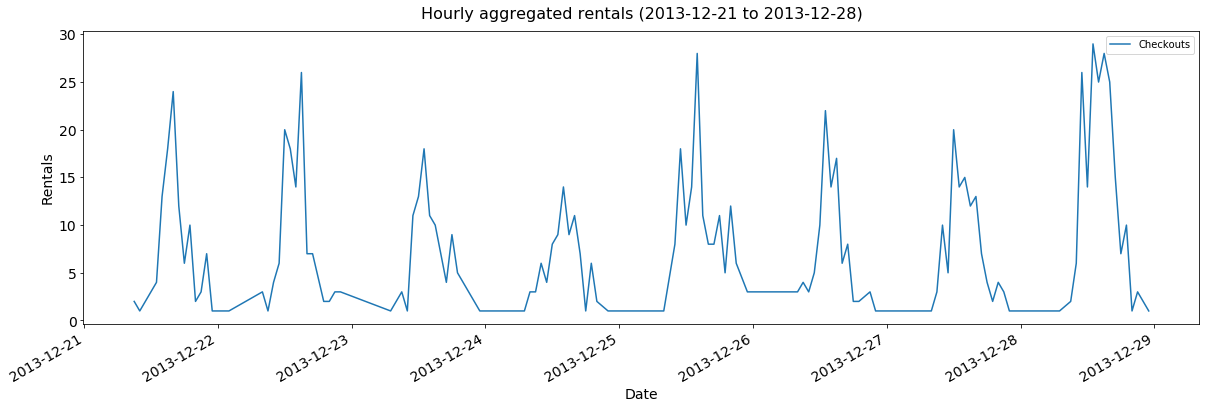

In [11]:
# Plot out the hourly bike rentals
def plot_rentals(df, cols, title, times=None):
    ''' Plots a time series data'''
    
    fig, ax = plt.subplots(1,1, figsize=(20,6))

    if times is not None:
        ax = df[times[0]:times[1]].plot(y=cols, ax=ax) # , color='black', style=['--', '-'])
        title += ' ({} to {})'.format(times[0], times[1])
    else:
        ax = df.plot(y=cols, ax=ax) # , color='black', style=['--', '-'])

    ax.set_xlabel('Date', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 16}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
#     ax.legend(['Hourly rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   

plot_rentals(hourly_checkouts, 'Checkouts', 'Hourly aggregated rentals', ('2013-12-21', '2013-12-28'))


In [12]:
# Wow - that looks spiky ! Let's smooth this out
def smooth_ts(df, halflife):
    '''Smooths time series data using ewma and halflife
    INPUT: Dataframe to smooth, halflife for Exponential Weighted Moving Average
    RETURNS: Smoothed dataframe
    '''
    smooth_df = df.ewm(halflife=halflife, ignore_na=False,adjust=True,min_periods=0).mean()
    smooth_df = smooth_df.shift(periods=-halflife)
    smooth_df = smooth_df.fillna(0)
    return smooth_df

# plot_df['original'] = hourly_df['rentals']
# plot_rentals(hourly_smooth_df, ['rentals', 'Hourly aggregated rentals', ('2016-04-01', '2016-04-08'))

smooth_df = smooth_ts(hourly_checkouts, 2)

# Using the WHOLE TIMELINE

In [13]:
hourly_checkouts.head()

,Day,Month,Year,DayofWeek,Hours,Temp,Precip,Wind Speed,Checkouts
datetime,,,,,,,,,
2013-12-21 09:00:00,21.0,12.0,2013.0,5.0,9.0,47.75,0.0592,5.82,2.0
2013-12-21 10:00:00,21.0,12.0,2013.0,5.0,10.0,47.75,0.0592,5.82,1.0
2013-12-21 13:00:00,21.0,12.0,2013.0,5.0,13.0,47.75,0.0592,5.82,4.0
2013-12-21 14:00:00,21.0,12.0,2013.0,5.0,14.0,47.75,0.0592,5.82,13.0
2013-12-21 15:00:00,21.0,12.0,2013.0,5.0,15.0,47.75,0.0592,5.82,18.0


In [14]:
# todo ! Define the style in one place to keep graphs consistent

# plt.style.use('fivethirtyeight')
# # plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Helvetica'
# plt.rcParams['font.monospace'] = 'Consolas'
# plt.rcParams['font.size'] = 10
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 8
# plt.rcParams['ytick.labelsize'] = 8
# plt.rcParams['legend.fontsize'] = 10
# plt.rcParams['figure.titlesize'] = 12

PLT_DPI = 150


def plot_ts(df, true, pred, title, ax):
    '''Generates one of the subplots to show time series'''
    plot_df = df.resample('1D').sum()
    ax = plot_df.plot(y=[pred, true], ax=ax) # , color='black', style=['--', '-'])
    ax.set_xlabel('', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title + ' time series', fontdict={'size' : 16}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    

def plot_scatter(true, pred, title, ax):
    '''Plots the results of a validation run on a scatter plot'''
    min_val = result_val_df.min().min() - 10.0
    max_val = result_val_df.max().max() + 20.0

    plt.scatter(x=true, y=pred)
    plt.axis('equal')
    plt.axis([min_val, max_val, min_val, max_val])
    plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='-', linewidth=1)
    
    ax.set_xlabel('Actual rentals', fontdict={'size' : 14})
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.set_ylabel('Predicted rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 16}) 

    filename = title.lower().replace(' ', '_')

def plot_all_results(df, true, pred, title):
    ''''''
    fig, ax = plt.subplots(1,2,figsize=(20,10), gridspec_kw={'width_ratios':[2,1]}, )
    plot_ts(df, true, pred, title, ax=ax[0])
    plot_scatter(df[true], df[pred], title, ax[1])
    filename=title.lower().replace(' ', '-').replace(',','')
    plt.savefig(filename, type='png', dpi=PLT_DPI, bbox_inches='tight')
    print('Saved file to {}'.format(filename))
    

In [15]:
from bcycle_lib.all_utils import add_time_features

TRAIN_START = '2013-01-01'
TRAIN_END = '2017-12-31'
VAL_START = '2018-01-01'
VAL_END = '2018-12-31'

hourly_trips_df = hourly_checkouts.copy()
hourly_trips_df = add_time_features(hourly_trips_df)
train_df = hourly_trips_df[TRAIN_START:TRAIN_END].copy()
val_df = hourly_trips_df[VAL_START:VAL_END].copy()

n_train = train_df.shape[0]
n_val = val_df.shape[0]
n_total = n_train + n_val
n_train_pct = (n_train / n_total) * 100.0
n_val_pct = (n_val / n_total) * 100.0

print('\nTraining data first and last row:\n{}\n{}'.format(train_df.index[0], train_df.index[-1]))
print('\nValidation data first and last row:\n{}\n{}\n'.format(val_df.index[0], val_df.index[-1]))

print('Train data shape: {}, {:.2f}% of rows'.format(train_df.shape, n_train_pct))
print('Validation data shape: {}, {:.2f}% of rows'.format(val_df.shape, n_val_pct))

train_df.head()


Training data first and last row:
2013-12-21 09:00:00
2017-12-31 20:00:00

Validation data first and last row:
2018-01-01 00:00:00
2018-09-30 23:00:00

Train data shape: (29015, 10), 82.38% of rows
Validation data shape: (6204, 10), 17.62% of rows


,Day,Month,Year,DayofWeek,Hours,Temp,Precip,Wind Speed,Checkouts,day-hour
datetime,,,,,,,,,,
2013-12-21 09:00:00,21.0,12.0,2013.0,5.0,9.0,47.75,0.0592,5.82,2.0,5-9
2013-12-21 10:00:00,21.0,12.0,2013.0,5.0,10.0,47.75,0.0592,5.82,1.0,5-10
2013-12-21 13:00:00,21.0,12.0,2013.0,5.0,13.0,47.75,0.0592,5.82,4.0,5-13
2013-12-21 14:00:00,21.0,12.0,2013.0,5.0,14.0,47.75,0.0592,5.82,13.0,5-14
2013-12-21 15:00:00,21.0,12.0,2013.0,5.0,15.0,47.75,0.0592,5.82,18.0,5-15


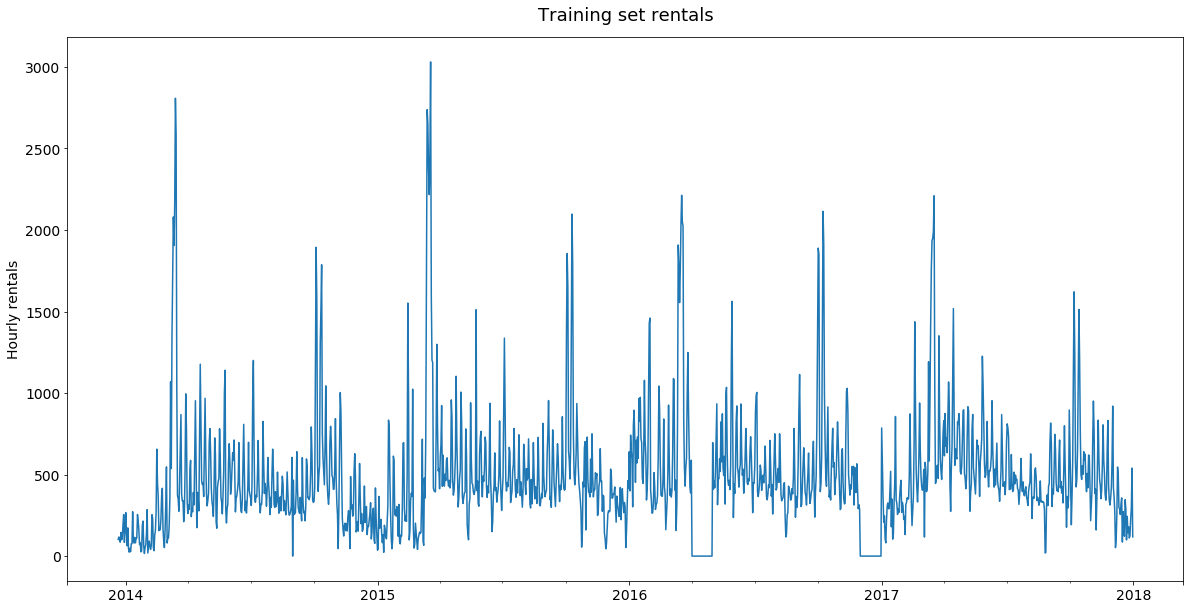

In [16]:
from bcycle_lib.all_utils import plot_lines

plot_df = train_df.resample('1D').sum()['Checkouts']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Training set rentals', 
                                 xlabel='', ylabel='Hourly rentals')


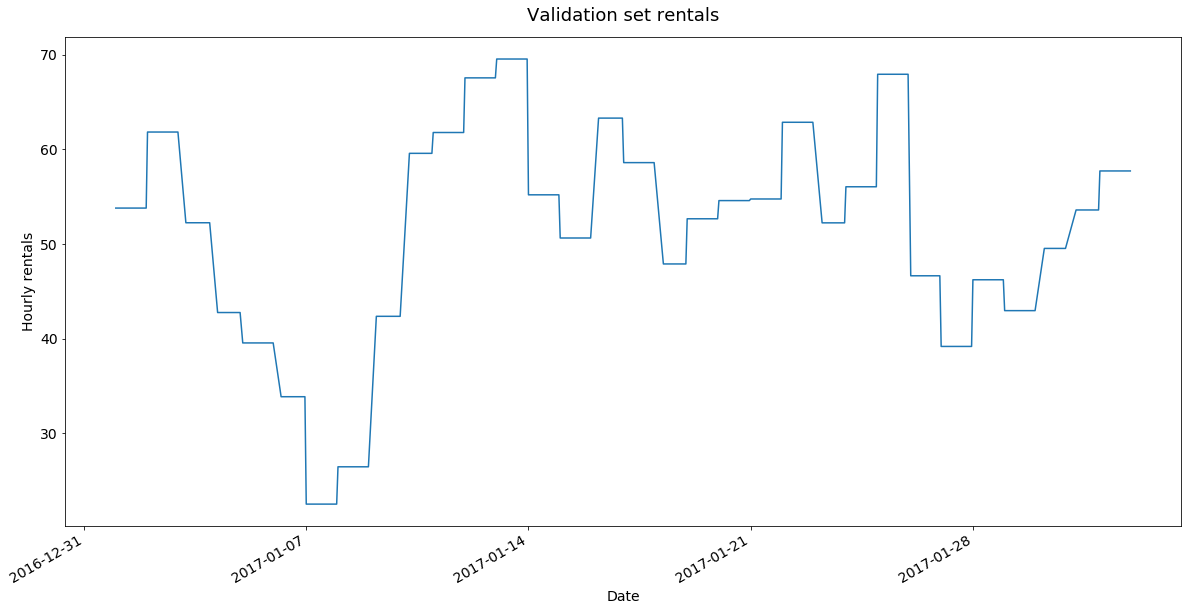

In [17]:
# Let's plot the validation set
plot_df = train_df['2017-01-01':'2017-02-01']['Temp']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Validation set rentals', 
                                 xlabel='Date', ylabel='Hourly rentals')

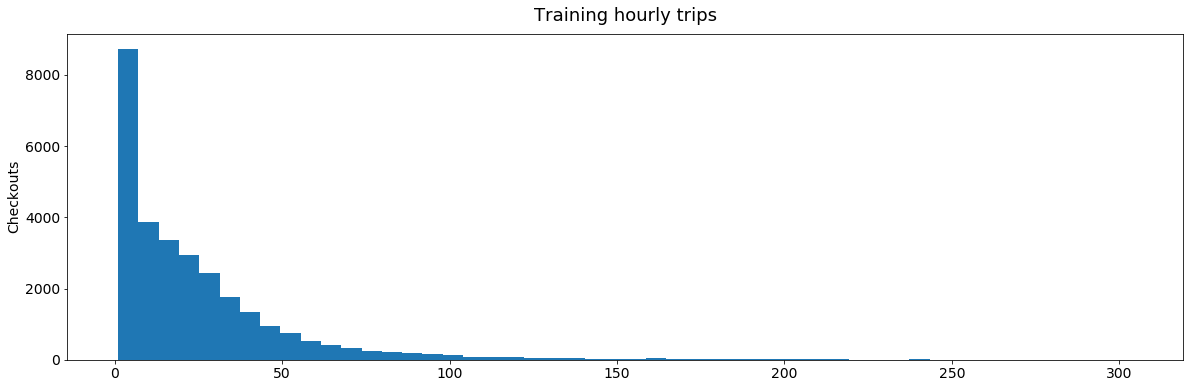

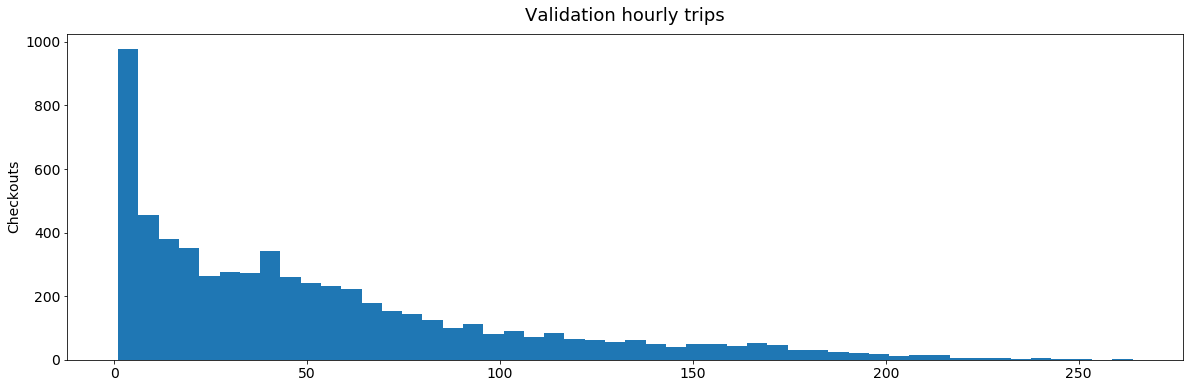

In [18]:
from bcycle_lib.all_utils import plot_hist
SIZE=(20,6)

plot_hist(train_df['Checkouts'], bins=50, size=SIZE, title='Training hourly trips', xlabel='', ylabel='Checkouts')
plot_hist(val_df['Checkouts'], bins=50, size=SIZE, title='Validation hourly trips', xlabel='', ylabel='Checkouts')

In [19]:
# First create a daily rentals dataframe, split it into training and validation
from bcycle_lib.all_utils import add_time_features

train_df = add_time_features(train_df)
val_df = add_time_features(val_df)

print('Training data shape: {}'.format(train_df.shape))
print('Validation data shape: {}'.format(val_df.shape))

Training data shape: (29015, 10)
Validation data shape: (6204, 10)


X_train shape: (29015, 168), y_train shape: (29015,)
X_val shape: (6204, 168), y_val shape: (6204,)
Hour-of-day baseline RMSE - Train: 21.92, Val: 53.14
Saved file to hour-of-day-baseline


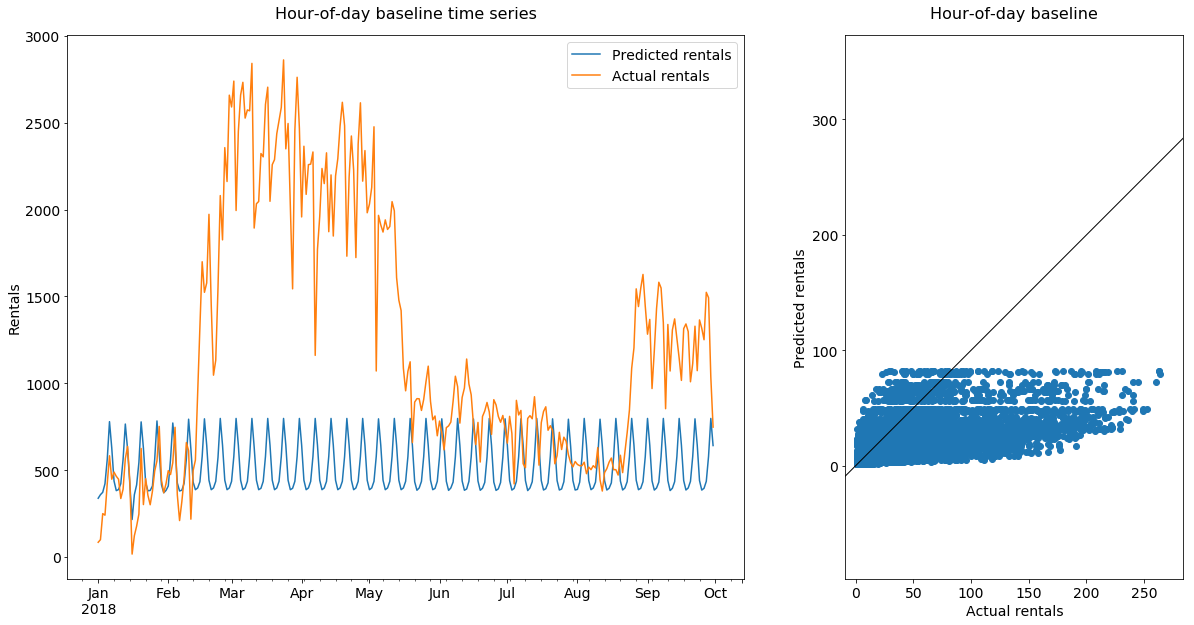

In [20]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df[['day-hour', 'Checkouts']], 
                                           target_col='Checkouts', 
                                           ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df[['day-hour', 'Checkouts']], 
                                     target_col='Checkouts', 
                                     ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from bcycle_lib.all_utils import df_from_results, plot_results, plot_val

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores_df = pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, index=['linreg_time'])

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                 val_df.index, y_val, y_val_pred)

print('Hour-of-day baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day baseline')

In [21]:
# Create a list of national holidays, with their observed dates days around them

holidays = {'hol_new_year' : ('2013-01-01', '2014-01-01','2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01'),
            
            'hol_mlk' : ('2013-01-21','2014-01-20','2015-01-19','2016-01-18','2017-01-16','2018-01-15'),
                              
            'hol_presidents' : ('2013-02-18','2014-02-17','2015-02-16','2016-02-15','2017-02-20','2018-02-19'),
                              
            'hol_memorial' : ('2013-05-27','2014-05-26','2015-05-25','2016-05-30','2017-05-29','2018-05-28'),
                              
            'hol_independence' : ('2013-07-04', '2014-07-04', '2015-07-04', '2016-07-04', '2017-07-04', '2018-07-04'),
                              
            'hol_labor' : ('2013-09-02', '2014-09-01', '2015-09-07', '2016-09-05', '2017-09-04', '2018-09-03'),
                              
            'hol_columbus' : ('2013-10-14','2014-10-13','2015-10-12','2016-10-10','2017-10-09','2018-10-08'),
                              
            'hol_veterans' : ('2013-11-11', '2014-11-11', '2015-11-11', '2016-11-11', '2017-11-11', '2018-11-11'),
                              
            'hol_thanksgiving' : ('2013-11-28','2014-11-27','2015-11-26','2016-11-24','2017-11-23','2018-11-22'),
                              
            'hol_christmas' : ('2013-12-25','2014-12-25','2015-12-25','2016-12-25','2017-12-25','2018-12-25',)
           }


# Now with Events

events = {'sxsw' : ('2013-03-08', '2014-03-07', '2015-03-13', '2016-03-11', '2017-03-10', '2018-03-12'),
          'acl_wk1' : ('2013-10-04', '2014-10-03', '2015-10-02', '2016-09-30', '2017-10-06', '2018-10-04'),
          'acl_wk2' : ('2013-10-11', '2014-10-10', '2015-10-09', '2016-10-07', '2017-10-13', '2018-10-11'),
          'trail_of_lights': ('2013-12-08','2014-12-07','2015-12-08','2016-12-10','2017-12-09','2018-12-10')
         }


def days_to_date(row, col, dates):
    days = np.array([])
    for date in dates[col]:
        time1 = row.name
        time2 = datetime.datetime.strptime(date, "%Y-%m-%d")
        elapsedTime = time2-time1
        days = np.append(days, divmod(elapsedTime.total_seconds(), 60*60*24)[0])
        
    day = days[np.argmin(np.abs(days))] + 1
    return day



for col in holidays:
    train_df[col] = train_df.apply(days_to_date, col=col, dates=holidays, axis=1)
    val_df[col] = val_df.apply(days_to_date, col=col, dates=holidays, axis=1)

for col in events:
    train_df[col] = train_df.apply(days_to_date, col=col, dates=events, axis=1)
    val_df[col] = val_df.apply(days_to_date, col=col, dates=events, axis=1)

In [22]:
# Check they were all added here 1
train_df.describe()
# train_df.head()

# train_df[train_df['event_sxsw'] == 1]

,Day,Month,Year,DayofWeek,Hours,Temp,Precip,Wind Speed,Checkouts,hol_new_year,...,hol_independence,hol_labor,hol_columbus,hol_veterans,hol_thanksgiving,hol_christmas,sxsw,acl_wk1,acl_wk2,trail_of_lights
count,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,...,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000,29015.000000
mean,15.767672,6.545511,2015.485576,3.026469,12.596071,66.197817,0.002290,6.129937,24.809685,3.601482,...,0.338928,3.328899,2.911287,7.022368,5.646390,4.167155,-1.902361,1.286921,2.856522,4.935930
std,8.775669,3.352427,1.140591,2.002993,6.559372,13.336624,0.018309,2.984591,28.573527,107.888756,...,102.463879,103.649132,103.711208,105.570785,105.901646,107.676867,108.230925,104.248347,104.320481,107.154866
min,1.000000,1.000000,2013.000000,0.000000,0.000000,22.540000,0.000000,0.000000,1.000000,-182.000000,...,-182.000000,-184.000000,-181.000000,-182.000000,-181.000000,-182.000000,-184.000000,-184.000000,-184.000000,-183.000000
25%,8.000000,4.000000,2014.000000,1.000000,8.000000,57.390000,0.000000,3.840000,6.000000,-88.000000,...,-87.000000,-80.000000,-88.000000,-87.000000,-87.000000,-88.000000,-98.000000,-89.000000,-89.000000,-89.000000
50%,16.000000,7.000000,2015.000000,3.000000,13.000000,69.040000,0.000000,5.820000,17.000000,5.000000,...,-2.000000,5.000000,7.000000,13.000000,12.000000,7.000000,-4.000000,5.000000,7.000000,12.000000
75%,23.000000,9.000000,2017.000000,5.000000,18.000000,76.905000,0.000000,8.130000,33.000000,99.000000,...,90.000000,90.000000,92.000000,99.000000,98.000000,99.000000,97.000000,90.000000,92.000000,98.000000
max,31.000000,12.000000,2017.000000,6.000000,23.000000,87.600000,0.413200,22.620000,304.000000,183.000000,...,183.000000,186.000000,182.000000,183.000000,182.000000,183.000000,186.000000,186.000000,186.000000,184.000000


In [23]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df.drop(['Day','Month','Year','Precip','Wind Speed','Temp'], axis=1),
                                    target_col='Checkouts', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df.drop(['Day','Month','Year','Precip','Wind Speed','Temp'], axis=1),
                                target_col='Checkouts', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (29015, 184), y_train shape: (29015,)
X_val shape: (6204, 184), y_val shape: (6204,)


Hour-of-day and events RMSE - Train: 20.45, Val: 50.91
Saved file to hour-of-day-with-events


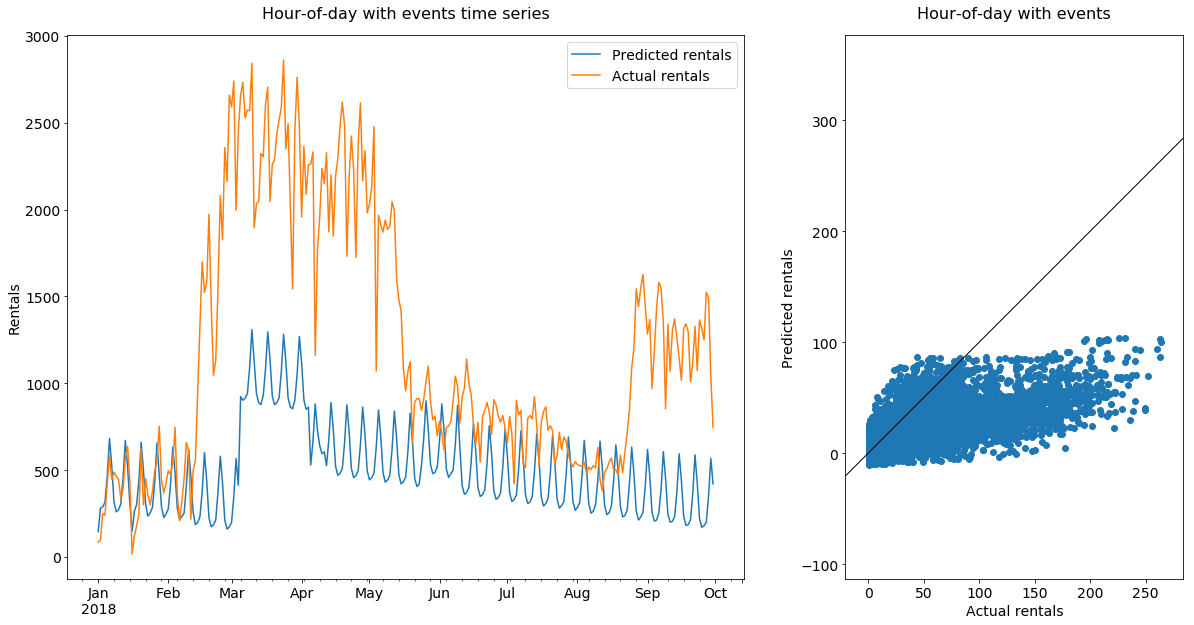

In [24]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events']))

print('Hour-of-day and events RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events')

In [25]:
def add_lag_time_features(df, col):
    """Adds time-lagged features to improve prediction
    INPUT: df - Dataframe with date index
           col - column in dataframe used to calculate lags
    RETURNS: Dataframe with extra lag features
    """
#     df[col + '_lag_1H'] = df[col].shift(1).fillna(method='backfill')
    df[col + '_lag_1D'] = df[col].shift(24 * 1).fillna(method='backfill')
    df[col + '_lag_2D'] = df[col].shift(24 * 2).fillna(method='backfill')
    df[col + '_lag_3D'] = df[col].shift(24 * 3).fillna(method='backfill')
    df[col + '_lag_4D'] = df[col].shift(24 * 4).fillna(method='backfill')
    df[col + '_lag_5D'] = df[col].shift(24 * 5).fillna(method='backfill')
    df[col + '_lag_6D'] = df[col].shift(24 * 6).fillna(method='backfill')
    df[col + '_lag_1W'] = df[col].shift(24 * 7).fillna(method='backfill')
    return df

def add_win_time_features(df, col):
    """Adds rolling window features to improve prediction
    INPUT: df - Dataframe with date index
           col - column in dataframe used to calculate lags
    RETURNS: Dataframe with extra window features
    """
    df[col + '_win_1D'] = df[col].rolling(window=24, win_type='blackman').mean().fillna(method='backfill')
    df[col + '_win_1W'] = df[col].rolling(window=24*7, win_type='blackman').mean().fillna(method='backfill')
    return df

def add_median_time_features(df, col):
    """Adds median bike rental values to correct for longer term changes
    """
    df[col + '_med_1D'] = df[col].shift(24).resample('1D').median()
    df[col + '_med_1D'] = df[col + '_med_1D'].fillna(method='ffill').fillna(0)
    df[col + '_med_1W'] = df[col].shift(24*7).resample('1W').median()
    df[col + '_med_1W'] = df[col + '_med_1W'].fillna(method='ffill').fillna(0)
    df[col + '_med_1M'] = df[col].shift(24*30).resample('1M').median()
    df[col + '_med_1M'] = df[col + '_med_1M'].fillna(method='ffill').fillna(0)

    return df


train_df = add_lag_time_features(train_df, 'Checkouts')
val_df   = add_lag_time_features(val_df  , 'Checkouts')

train_df = add_win_time_features(train_df, 'Checkouts')
val_df   = add_win_time_features(val_df  , 'Checkouts')

train_df = add_median_time_features(train_df, 'Checkouts')
val_df   = add_median_time_features(val_df  , 'Checkouts')

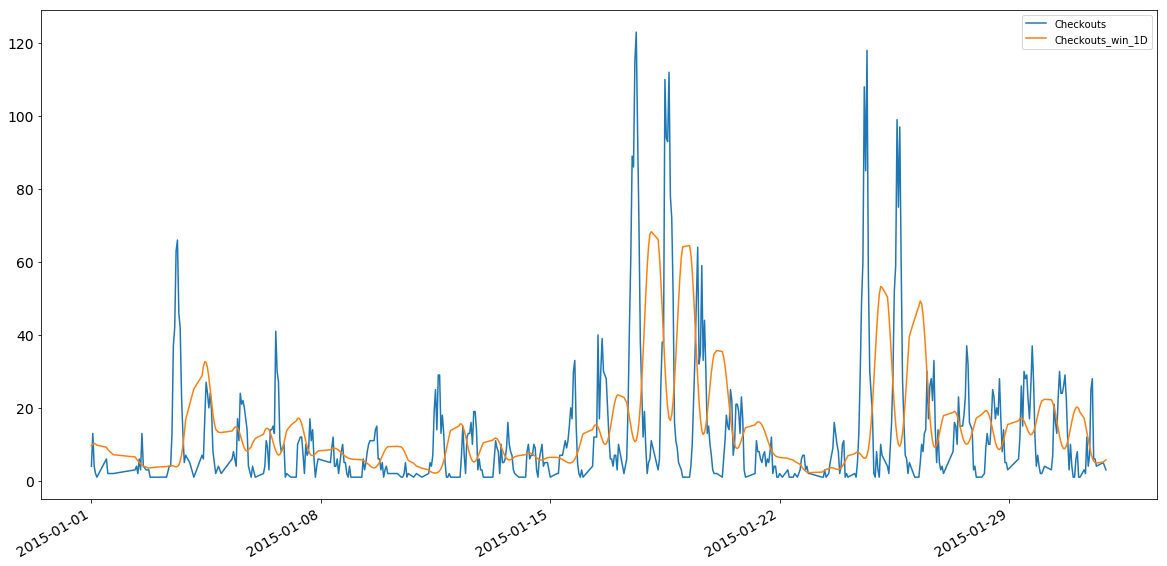

In [26]:
# # Lag features
plot_df = train_df['2015-01-01':'2015-01-31']
plot_lines(plot_df[['Checkouts', 'Checkouts_win_1D']], plt.subplots(1,1,figsize=(20,10)), title='', xlabel='', ylabel='')

In [27]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df.drop(['Day','Month','Year','Precip','Wind Speed','Temp'], axis=1),
                                    target_col='Checkouts', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df.drop(['Day','Month','Year','Precip','Wind Speed','Temp'], axis=1),
                                target_col='Checkouts', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (29015, 196), y_train shape: (29015,)
X_val shape: (6204, 196), y_val shape: (6204,)


Hour-of-day with events and lags RMSE - Train: 17.19, Val: 28.24
Saved file to hour-of-day-with-events-and-lags


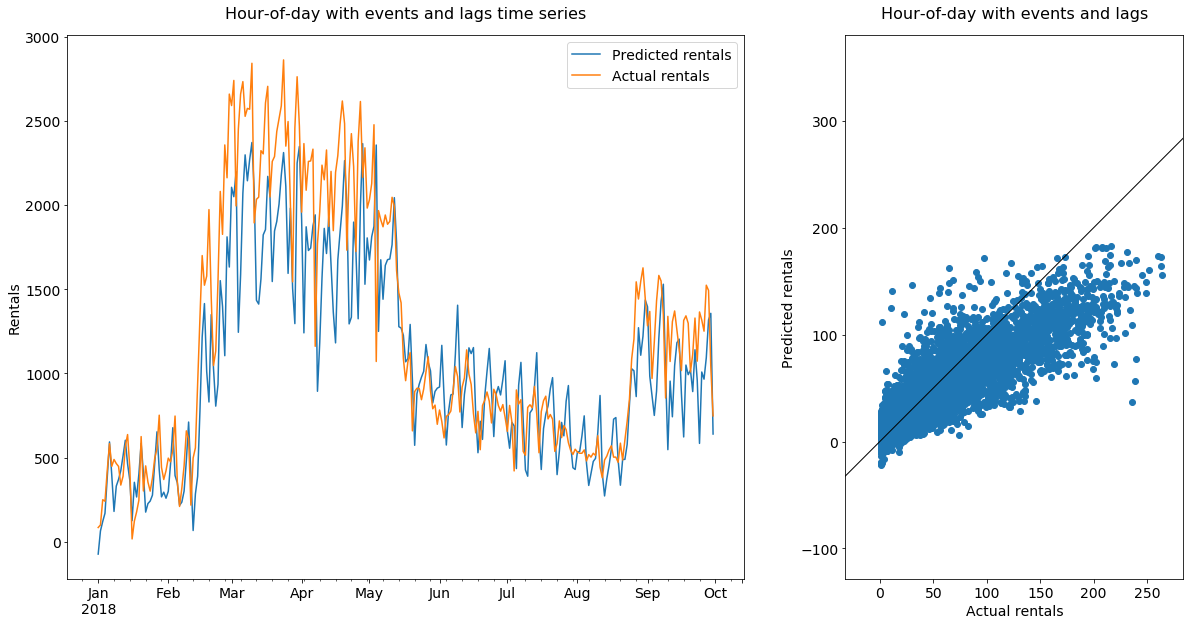

In [28]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events_lags' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events_lags']))

print('Hour-of-day with events and lags RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events and lags')

In [29]:
# # Merge the training and validation datasets with the weather dataframe

GOOD_COLS = ['Temp', 'Precip', 'Wind Speed']


train_weather_df = pd.concat([train_df.drop(['Day','Month','Year','Precip','Wind Speed','Temp'], axis=1), hourly_checkouts[GOOD_COLS][train_df.iloc[0].name:train_df.iloc[-1].name]], axis = 1)
val_weather_df = pd.concat([val_df.drop(['Day','Month','Year','Precip','Wind Speed','Temp'], axis=1), hourly_checkouts[GOOD_COLS][val_df.iloc[0].name:val_df.iloc[-1].name]], axis = 1)

train_weather_df.head()

,DayofWeek,Hours,Checkouts,day-hour,hol_new_year,hol_mlk,hol_presidents,hol_memorial,hol_independence,hol_labor,...,Checkouts_lag_6D,Checkouts_lag_1W,Checkouts_win_1D,Checkouts_win_1W,Checkouts_med_1D,Checkouts_med_1W,Checkouts_med_1M,Temp,Precip,Wind Speed
datetime,,,,,,,,,,,,,,,,,,,,,
2013-12-21 09:00:00,5.0,9.0,2.0,5-9,11.0,30.0,58.0,156.0,-170.0,-110.0,...,2.0,2.0,5.607196,8.742563,0.0,0.0,0.0,47.75,0.0592,5.82
2013-12-21 10:00:00,5.0,10.0,1.0,5-10,11.0,30.0,58.0,156.0,-170.0,-110.0,...,2.0,2.0,5.607196,8.742563,0.0,0.0,0.0,47.75,0.0592,5.82
2013-12-21 13:00:00,5.0,13.0,4.0,5-13,11.0,30.0,58.0,156.0,-170.0,-110.0,...,2.0,2.0,5.607196,8.742563,0.0,0.0,0.0,47.75,0.0592,5.82
2013-12-21 14:00:00,5.0,14.0,13.0,5-14,11.0,30.0,58.0,156.0,-170.0,-110.0,...,2.0,2.0,5.607196,8.742563,0.0,0.0,0.0,47.75,0.0592,5.82
2013-12-21 15:00:00,5.0,15.0,18.0,5-15,11.0,30.0,58.0,156.0,-170.0,-110.0,...,2.0,2.0,5.607196,8.742563,0.0,0.0,0.0,47.75,0.0592,5.82


In [30]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_weather_df,
                                    target_col='Checkouts', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_weather_df,
                                target_col='Checkouts', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (29015, 199), y_train shape: (29015,)
X_val shape: (6204, 199), y_val shape: (6204,)


Hour-of-day, events, lags, and weather RMSE - Train: 17.15, Val: 27.88
Saved file to hour-of-day-with-events-lags-and-weather


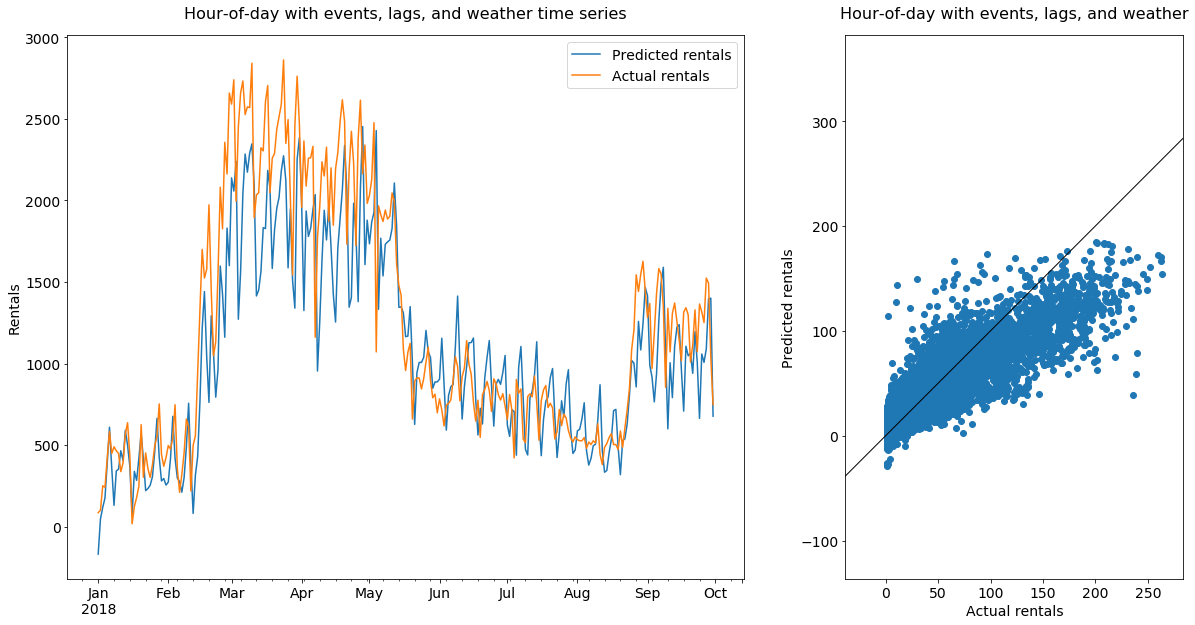

In [31]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events_lags_weather' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events_lags_weather']))

print('Hour-of-day, events, lags, and weather RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events, lags, and weather')

In [30]:
from scipy.signal import welch
from scipy.fftpack import fft
import numpy as np
from bcycle_lib.detect_peaks import detect_peaks

N = 512
f_s = 50
t_n = 2.56
T = t_n / N
columns = ['Temp', 'Checkouts']
no_peaks = 5
denominator = 10

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values


def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    indices_peaks = sorted(i for i in indices_peaks if i <= N-1)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def create_col_labels(columns):
    labels = pd.DataFrame()
    for col in columns:
        temp = []
        axes=['psdx','psdy','fftx','ffty','autox','autoy']
        for ax in axes:
            for i in range(0,no_peaks):
                temp += [col + ' ' + ax + str(i%5)]
        kwargs = {col : pd.Series(temp)}
        labels = labels.assign(**kwargs)
    return labels

def extract_features_labels(dataset, T, N, f_s, denominator, columns):
    col_labels = create_col_labels(columns)
    percentile = 5
    list_of_features = pd.Series([])
    for col in columns:
        features = []
        signal = dataset[col]
        if len(signal) == 0:
            list_of_features = list_of_features.append(pd.Series([0]*(no_peaks*3*2), col_labels[col]))
        else:
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator

            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
            list_of_features = list_of_features.append(pd.Series(features, col_labels[col]))
    return (list_of_features)


def extract_features_from_row(df):
    col_labels = create_col_labels(columns)
    for col in col_labels.values.ravel('F'):
        df[col] = 0
    for i, row in df.iterrows():
        new_features = extract_features_labels(df[(row.name - datetime.timedelta(days=31)):(row.name - datetime.timedelta(days=1))], 
                                T, N, f_s, denominator, columns)

        for feature in new_features.index:
            df.at[i, feature] = new_features[feature]

            
combined_df = pd.concat([train_weather_df, val_weather_df])
extract_features_from_row(df=combined_df)


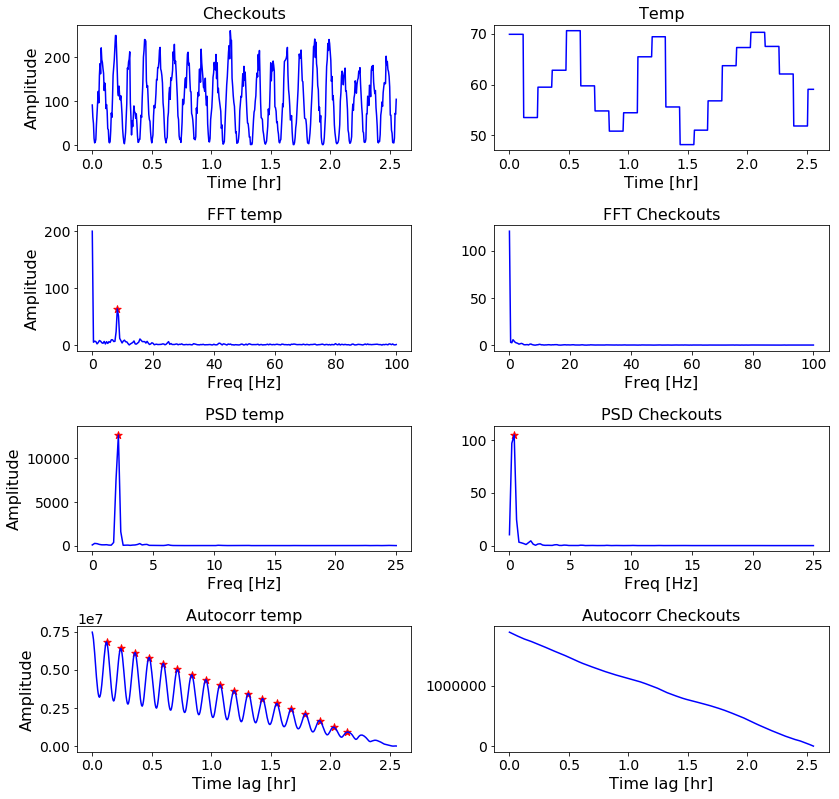

In [31]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [T * kk for kk in range(0,len(y_values))]
    return x_values, y_values
 
####
DATE_START = '2018-03-01'


colors = ['b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [hr]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [hr]']
ylabel = 'Amplitude'
axtitles = [['Checkouts', 'Temp'],
            ['FFT temp', 'FFT Checkouts'],
            ['PSD temp', 'PSD Checkouts'],
            ['Autocorr temp', 'Autocorr Checkouts']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

signal_no = 0
signals = [combined_df[DATE_START:].iloc[:N]['Checkouts'].values, 
           combined_df[DATE_START:].iloc[:N]['Temp'].values]

label = columns[signal_no]
 
f, axarr = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
 
for row_no in range(0,4):
    for comp_no in range(0,2):
        col_no = comp_no // 1
        plot_no = comp_no % 1
        color = colors[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c='r', marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.savefig('transforms.png', dpi=PLT_DPI, bbox_inches='tight')
plt.show()

In [32]:
#recreate the training and validation sets
combined_df = pd.concat([train_weather_df, val_weather_df])

train_transform_df = combined_df[TRAIN_START:TRAIN_END].copy()
val_transform_df = combined_df[VAL_START:VAL_END].copy()

In [33]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_transform_df,
                                    target_col='Checkouts', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_transform_df,
                                target_col='Checkouts', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (29015, 199), y_train shape: (29015,)
X_val shape: (6204, 199), y_val shape: (6204,)


Hour-of-day, events, lags, weather, and transforms RMSE - Train: 17.00, Val: 38.10
Saved file to hour-of-day-with-events-lags-weather-and-transforms


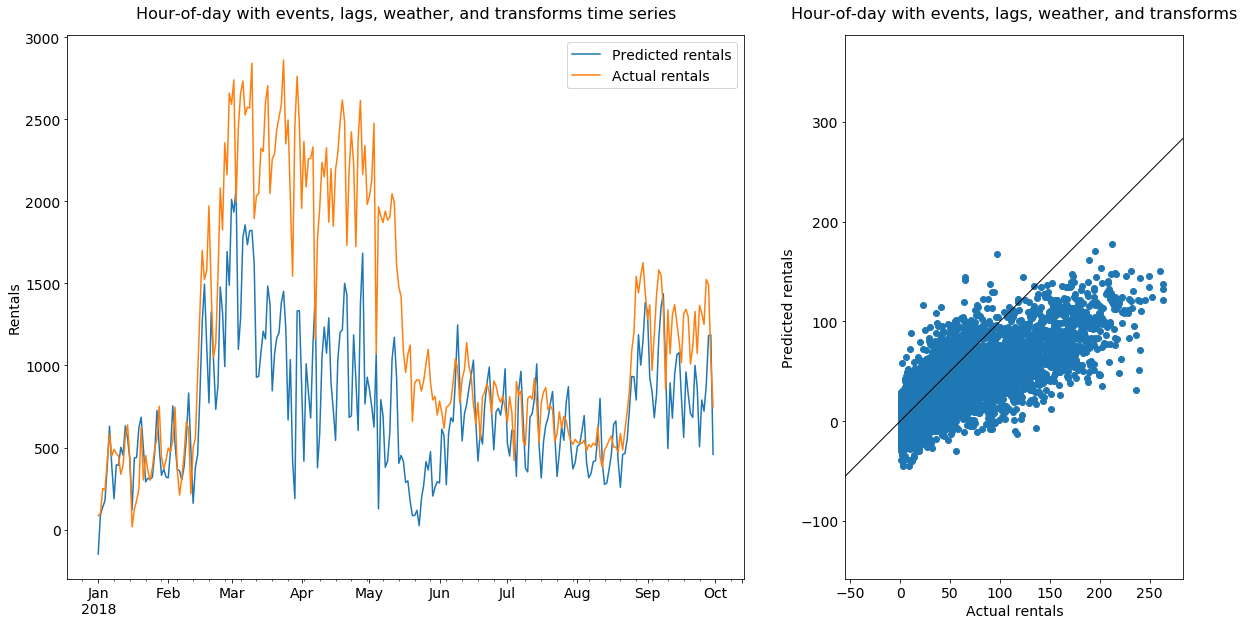

In [34]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events_lags_weather_transforms' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events_lags_weather_transforms']))

print('Hour-of-day, events, lags, weather, and transforms RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events, lags, weather, and transforms')

# Weekly, Daily, and Hourly accuracy:

In [35]:
pD1 = np.mean(np.sqrt(np.square(result_val_df.resample('7D').sum()['true'] - result_val_df.resample('7D').sum()['pred'])))
aD1 = np.mean(result_val_df.resample('7D').sum()['true'])
(aD1-pD1)/aD1

0.6072011100997405

In [36]:
pD1 = np.mean(np.sqrt(np.square(result_val_df.resample('1D').sum()['true'] - result_val_df.resample('1D').sum()['pred'])))
aD1 = np.mean(result_val_df.resample('1D').sum()['true'])
(aD1-pD1)/aD1

0.5772404116524521

In [37]:
pD1 = np.mean(np.sqrt(np.square(result_val_df.resample('1H').sum()['true'] - result_val_df.resample('1H').sum()['pred'])))
aD1 = np.mean(result_val_df.resample('1H').sum()['true'])
(aD1-pD1)/aD1

0.5077246175731018

,train_rmse,val_rmse
linreg_time,21.92,53.14
linreg_time_events,20.45,50.91
linreg_time_events_lags,17.19,28.24
linreg_time_events_lags_weather,17.15,27.88


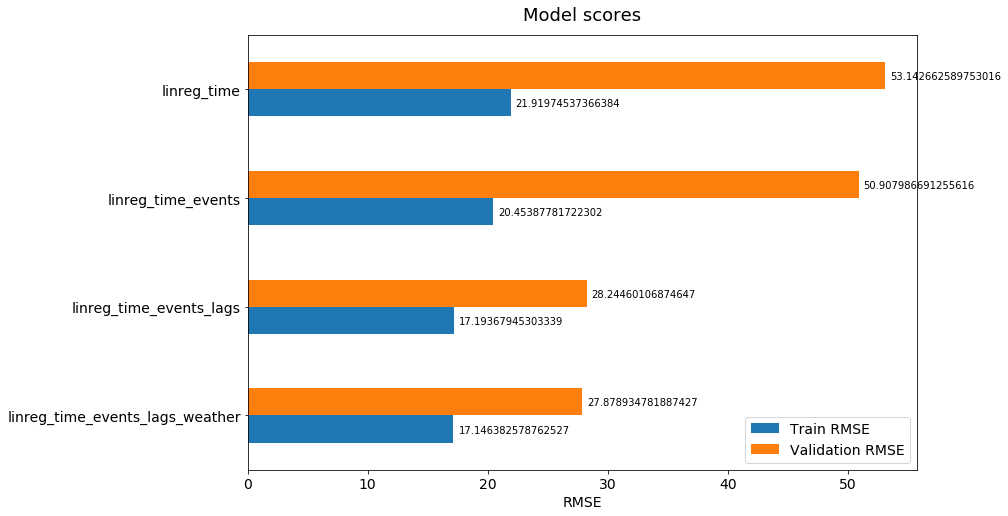

In [37]:
from bcycle_lib.all_utils import plot_scores
plot_scores(scores_df, 'Model scores', 'val_rmse')
plt.savefig('linear_scores.png', dpi=PLT_DPI, bbox_inches='tight')

scores_df.round(2)

In [34]:
from sklearn.preprocessing import StandardScaler

def model_eval(model, X_train, y_train, X_val, y_val, verbose=False):
    '''Evaluates model using training and validation sets'''
    
    if verbose:
        print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
        print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
    
    reg = model
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                             val_df.index, y_val, y_val_pred)

    out = {'train_rmse' : train_rmse, 
           'val_rmse' : val_rmse,
           'result_train' : result_train_df,
           'result_val' : result_val_df}
    
    print('RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

    return out

In [35]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, \
                                 LassoLars, BayesianRidge, HuberRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, \
                                    LeaveOneOut, RandomizedSearchCV, \
                                    learning_curve, GridSearchCV

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import TimeSeriesSplit

verbose = False
rs = 1738
tscv = TimeSeriesSplit(n_splits=5)

C:\Users\Jared\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RMSE - Train: 17.15, Val: 27.86
RMSE - Train: 17.15, Val: 27.88
RMSE - Train: 21.49, Val: 31.89
RMSE - Train: 22.46, Val: 37.74
RMSE - Train: 17.15, Val: 27.89
RMSE - Train: 21.50, Val: 31.94
RMSE - Train: 28.57, Val: 58.06
RMSE - Train: 5.04, Val: 34.26
RMSE - Train: 14.24, Val: 29.68


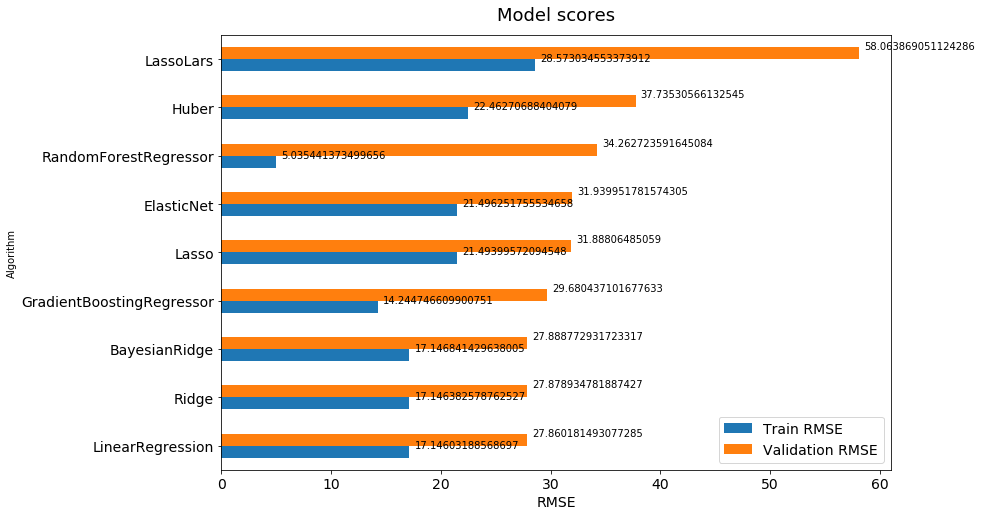

In [38]:
#testing baseline classifiers
X_train, y_train, _ = reg_x_y_split(train_transform_df, target_col='Checkouts',  ohe_cols=['day-hour'], verbose=verbose)
X_val, y_val, _ = reg_x_y_split(val_transform_df, target_col='Checkouts',  ohe_cols=['day-hour'], verbose=verbose)

classifiers = []
classifiers.append(LinearRegression())
classifiers.append(Ridge(random_state=rs))
classifiers.append(Lasso(random_state=rs))
classifiers.append(HuberRegressor())
classifiers.append(BayesianRidge())
classifiers.append(ElasticNet(random_state=rs))
classifiers.append(LassoLars())
#classifiers.append(MLPRegressor(random_state=rs))
classifiers.append(RandomForestRegressor(random_state=rs))
classifiers.append(GradientBoostingRegressor(random_state=rs))

cv_results = np.array([])
for classifier in classifiers :
    cv_results = np.append(cv_results, model_eval(classifier, X_train, y_train, X_val, y_val, verbose=verbose))

train_rmse = np.array([])
val_rmse = np.array([])
for cv_result in cv_results:
    train_rmse = np.append(train_rmse, cv_result['train_rmse'])
    val_rmse = np.append(val_rmse, cv_result['val_rmse'])

cv_res = pd.DataFrame({"Train RMSE":train_rmse,\
                       "Val RMSE":val_rmse,\
                       "Algorithm":['LinearRegression', 'Ridge', 'Lasso', \
                                    'Huber', 'BayesianRidge', 'ElasticNet',\
                                    'LassoLars',#'MLPRegressor',\
                                    'RandomForestRegressor', \
                                    'GradientBoostingRegressor'
                                   ]})

plot_scores(cv_res.set_index('Algorithm'), 'Model scores', 'Val RMSE')
plt.savefig('multimodel_scores.png', dpi=PLT_DPI, bbox_inches='tight')

In [43]:
#hyper parameter tuning: Gradient Boosting Regressor
total_df = pd.concat([train_transform_df, val_transform_df])

X_train, y_train, _ = reg_x_y_split(total_df, target_col='Checkouts',  ohe_cols=['day-hour'], verbose=verbose)

GBR = GradientBoostingRegressor(random_state=rs)
gbr_param_grid = {"learning_rate" : [.05, .1],
                  'n_estimators' : [50, 100, 150],
                  'max_depth': [2,3,6]                                
                 }

gsGBR = GridSearchCV(GBR, param_grid = gbr_param_grid, cv=tscv, 
                          scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsGBR.fit(X_train,y_train)

GBR_best = gsGBR.best_estimator_

# Best score
gsGBR.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 19.5min finished


-409.251275052642

In [44]:
X_train, y_train, _ = reg_x_y_split(train_transform_df, target_col='Checkouts',  ohe_cols=['day-hour'], verbose=verbose)
X_val, y_val, _ = reg_x_y_split(val_transform_df, target_col='Checkouts',  ohe_cols=['day-hour'], verbose=verbose)

results_1 = model_eval(GBR_best, X_train, y_train, X_val, y_val, verbose=verbose)

RMSE - Train: 13.68, Val: 28.95


Saved file to tuned-gradient-boosting-regressor


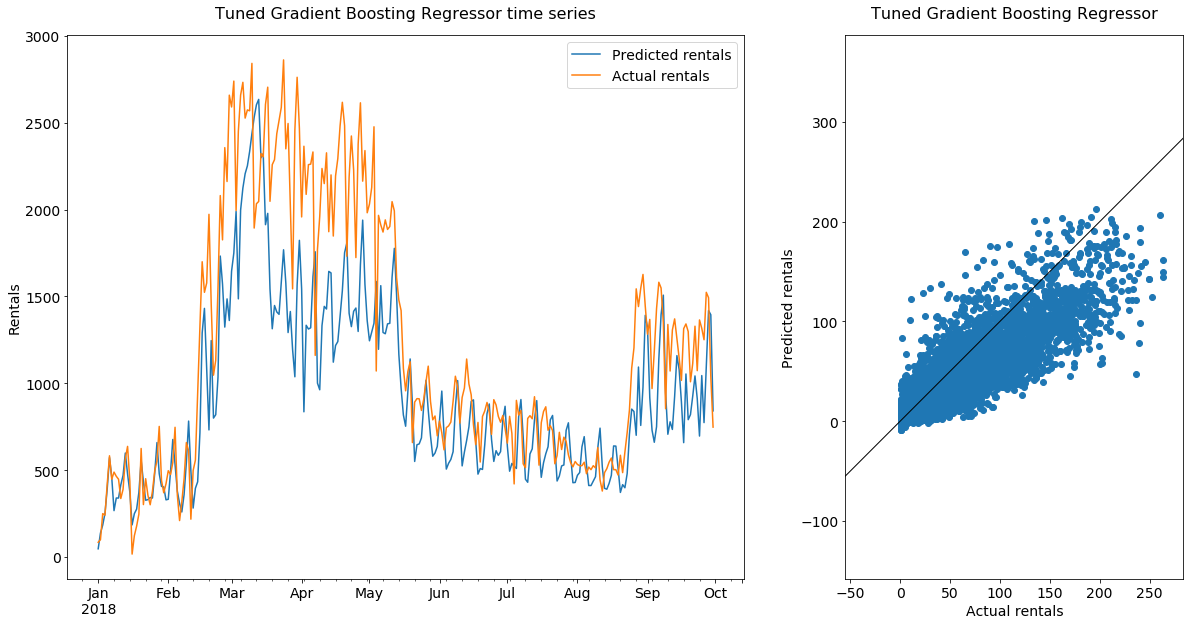

In [48]:
plot_all_results(results_1['result_val'], 'true', 'pred', 'Tuned Gradient Boosting Regressor')